## Dipolar Wakefield simulation 
> of the LHC unshielded bellows with Wakis

**Including:**
* Creation of the geometry from simple geometry blocks (CSG) 
    - *Fully parametrized* `r`, `l`, `n_conv` 
* Applying mesh refinement to match grid to convolution's edges
* Applying MPI domain splitting 
* Simulation of the Dipolar X impedance and wake and compare to CST

In [ ]:
# import ipyparallel as ipp
# cluster = ipp.Cluster(engines="mpi", n=2).start_and_connect_sync()

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

pv.global_theme.trame.server_proxy_enabled = True
pv.global_theme.trame.server_proxy_prefix = '/proxy/'
pv.global_theme.window_size = [600, 400]

### Geometry generation using Constructive Solid Geometry (CSG)

In [12]:
# Generate beam pipe
r_pipe = 24e-3      # pipe radius [m]
l_pipe = 320e-3     # pipe length [m]
pipe = pv.Cylinder(center=(0,0,0), direction=(0,0,1), radius=r_pipe, height=l_pipe)

# Generate bellow convolutions
r_conv = 30e-3   # convolution radius [m]
l_conv = 4e-3    # length of each convolution [m]
n_convs = [25, 18, 15]      # number of convolutions
l_between_conv = 4e-3  # length between convolutions [m]

# Parametric generation of geometry
bellows = []
for n_conv in n_convs:
    print(f'Generating bellow with {n_conv} convolutions...')
    convolutions = []
    z_start = n_conv//2*(l_conv + l_between_conv) - l_conv # start of the convolutions [m]
    for n in range(n_conv):
        z_start_n_conv = -z_start+n*(l_conv+l_between_conv)
        conv = pv.Cylinder(center=(0,0,z_start_n_conv), # center of the convolution
                           direction=(0,0,1),           # z-direction
                           radius=r_conv,
                           height=l_conv)
        convolutions.append(conv)                       # append to list

    # Sum the generated geometry
    pipe = pipe.triangulate()                          # triangulate pipe
    convolutions = np.sum(convolutions).triangulate()  # triangulate convolutions
    bellow = pipe | convolutions  # union of meshes without internal faces
    bellows.append(bellow)

# 3D Plot
pl = pv.Plotter()
pl.add_mesh(bellows[0], color='r',)
pl.add_mesh(bellows[1], color='b',)
pl.add_mesh(bellows[2], color='g',)
pl.show()

Generating bellow with 25 convolutions...
Generating bellow with 18 convolutions...
Generating bellow with 15 convolutions...


Widget(value='<iframe src="/proxy/46371/index.html?ui=P_0x7adc9104ddd0_5&reconnect=auto" class="pyvista" style…

In [14]:
# Save 15 conv bellow to STL file
stl_file = 'data/002_LHC_Bellow_generated.stl'
bellow.save(stl_file)               #save in [m]
# bellow.scale(1e3).save(stl_file)  #save in [mm]

In [ ]:

# [OPTIONAL] Plot the generated geometry
bellow.clear_data()
bellow.plot(opacity=0.7)

### Domain setup and grid generation

In [4]:
# ---------- Domain setup ---------
# Set up geometry & materials dictionaries
stl_file = 'data/002_LHC_Bellow_generated.stl'
stl_solids = {'bellow': stl_file}
stl_materials = {'bellow': 'vacuum'}

# Domain bounds
bellow = pv.read(stl_file)
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Number of mesh cells
Nx = 60
Ny = 60
Nz = 200
print(f'Total number of mesh cells: {Nx*Ny*Nz}')

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz,
                stl_solids=stl_solids,
                stl_materials=stl_materials,
                use_mesh_refinement=False,
                refinement_tol=1e-8,)

Total number of mesh cells: 720000
Generating grid with 720000 mesh cells...
Importing STL solids...
Total grid initialization time: 5.583436012268066 s


In [16]:
# [OPTIONAL] Inspect grid with a 3D interactive plot
grid.inspect()

Widget(value='<iframe src="/proxy/46371/index.html?ui=P_0x7adc78372fd0_6&reconnect=auto" class="pyvista" style…

In [5]:
# [OPTIONAL] Save grid to HDF5 file
grid.save_to_h5(f'002_grid_Nx{Nx}Ny{Ny}Nz{Nz}.h5')

Saving grid to HDF5 file: 002_grid_Nx60Ny60Nz200.h5


In [6]:
# [OPTIONAL] Load grid from HDF5 file or re-instantiate grid from file
# grid.load_from_h5('data/006_bellow_grid.h5')
grid = GridFIT3D(load_from_h5='002_grid_Nx60Ny60Nz200.h5', verbose=2)
grid.verbose=1

Loading grid from HDF5 file: 002_grid_Nx60Ny60Nz200.h5
Loaded grid with 720000 mesh cells:
 * Number of cells: Nx=60, Ny=60, Nz=200
 * Simulation domain bounds: 
                x:[-0.030, 0.030],
                y:[-0.030, 0.030],
                z:[-0.160, 0.160]
 * STL solids imported:
                ['bellow']
 * STL solids assigned materials [eps_r, mu_r, sigma]:
                ['vacuum']


In [23]:
# Inspect the cells occupied by the imported solid
pv.global_theme.window_size = [800, 400]
grid.plot_stl_mask(stl_solid='bellow', stl_opacity=0.2, ymax=0)

Widget(value='<iframe src="/proxy/46371/index.html?ui=P_0x7adc5824c050_9&reconnect=auto" class="pyvista" style…

### Wakefield settings

In [7]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 30e-3      #[m] 50mm -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta
xs = 8e-3           # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]

# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = 20  # no. cells to skip from wake integration (>= PML cells)

results_folder = f'002_results/'
wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, 
                xtest=xt, ytest=yt,
                skip_cells=skip_cells,
                wakelength=wakelength,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

### Boundary conditions and EM solver

In [10]:
# boundary conditions
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

n_pml = 10 # number of PML layers
solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high,
                     use_stl=True,
                     use_gpu=False,
                     bg='pec',  # background material
                     n_pml=n_pml,
                     dtype=np.float32,
                     )

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Filling PML sigmas...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 0.32488155364990234 s


In [11]:
solver.inspect(add_silhouette=True)

Widget(value='<iframe src="/proxy/39151/index.html?ui=P_0x796a2176ab50_1&reconnect=auto" class="pyvista" style…

In [12]:
# Plot settings
# import os
# if not os.path.exists(results_folder+'img/'):
#     os.mkdir(results_folder+'img/')

plotkw = {'title':results_folder+'img/Ez',
            'add_patch':'bellow', 'patch_alpha':0.3,
            'vmin':-1e4, 'vmax':1e4,
            'plane': [int(grid.Nx/2), slice(0, grid.Ny), slice(0, grid.Nz)],}

solver.wakesolve(wakelength=wakelength,
                 wake=wake,
                 plot=False,
                 plot_from=1000,
                 plot_every=50,
                 plot_until=6000,
                 **plotkw)

Running electromagnetic time-domain simulation...


100%|████████████████████████████████████████████████████████████████████████████| 32700/32700 [02:57<00:00, 184.40it/s]


Reading h5 file 002_results/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|████████████████████████████████████████████████████████████████████████| 285453/285453 [00:24<00:00, 11753.55it/s]


Calculating transverse wake potential WPx, WPy...


100%|███████████████████████████████████████████████████████████████████████| 285453/285453 [00:00<00:00, 341246.60it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


### Results
We can post-process the computed results, or load previous reuslts folder previously generated:

In [13]:
# Load previously computed results
from wakis import WakeSolver
wake = WakeSolver(sigmaz=15e-3, xsource=8e-3)
wake.load_results('002_results')

# Recompute wake potential and impedance (longitudinal and transverse)
# Modify the number of cells skip from the boundary during integration
# to aboid boundary artifacts -useful in low impedance devices!
wake.solve(skip_cells=40)

Reading h5 file 002_results/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|████████████████████████████████████████████████████████████████████████| 281880/281880 [00:19<00:00, 14167.13it/s]


Calculating transverse wake potential WPx, WPy...


100%|███████████████████████████████████████████████████████████████████████| 281880/281880 [00:00<00:00, 340415.15it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


In [19]:
# Recompute the longitudinal and transverse impedance
# with a different maximum frequency and number of samples
wake.calc_long_Z(fmax=3e9, samples=2000)
wake.calc_trans_Z(fmax=3e9, samples=2000)

Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


It's done! Now we can plot the results:

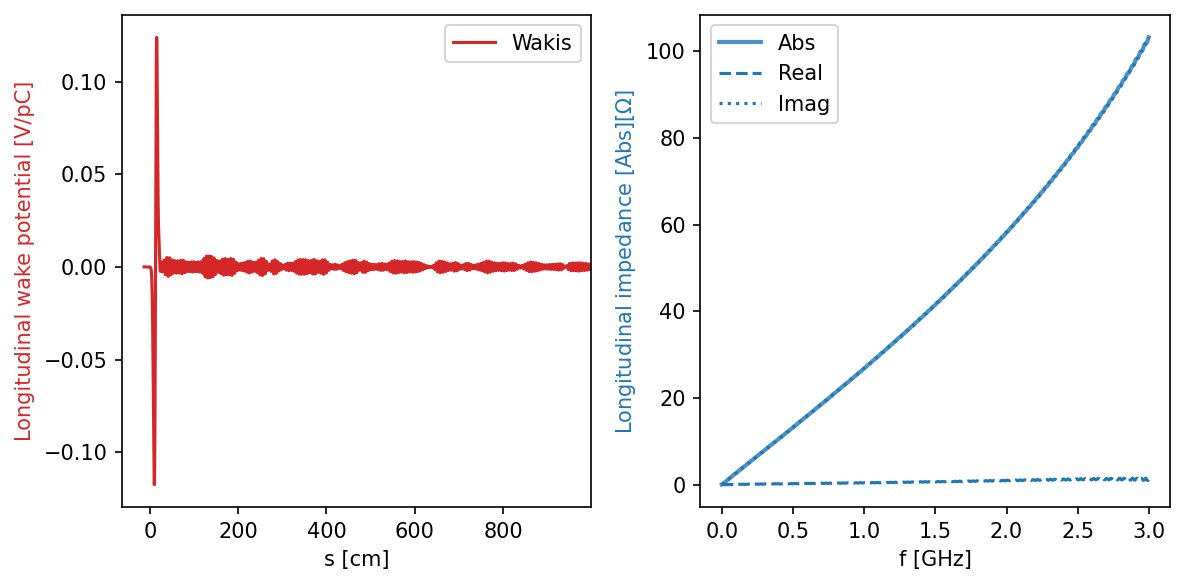

In [29]:
# Plot longitudinal wake potential and impedance
fig1, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()
#fig1.savefig(results_folder+'longitudinal.png')
#plt.show()

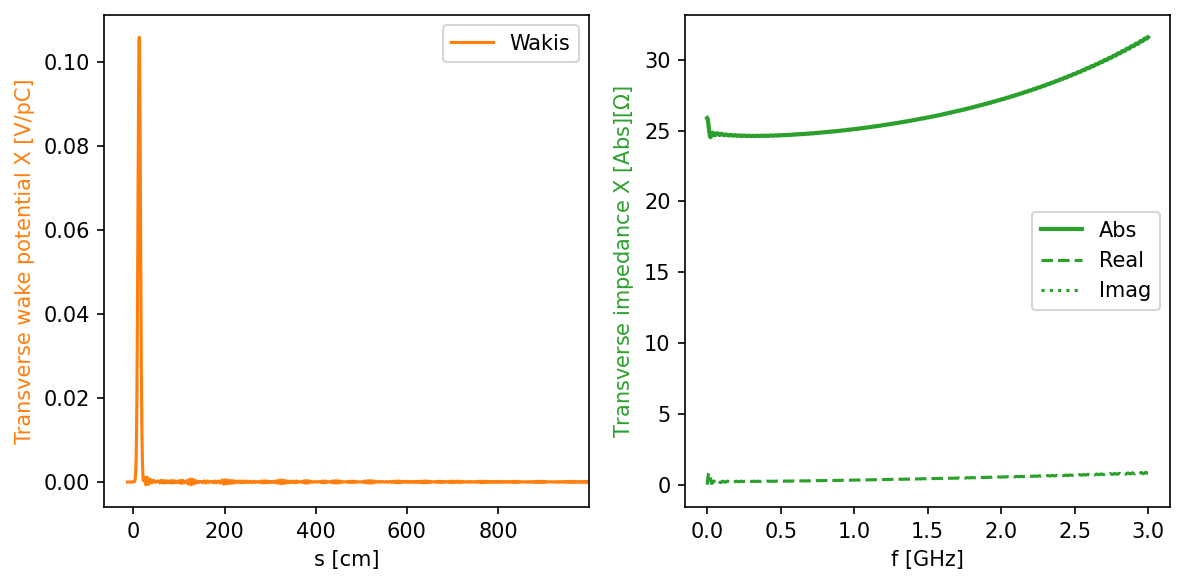

In [25]:
# Plot transverse x wake potential and impedance
fig2, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance X [Abs][$\Omega$]', color='tab:green')
ax[1].legend()

fig2.tight_layout()
#fig2.savefig(results_folder+'transverse_x.png')
#plt.show()

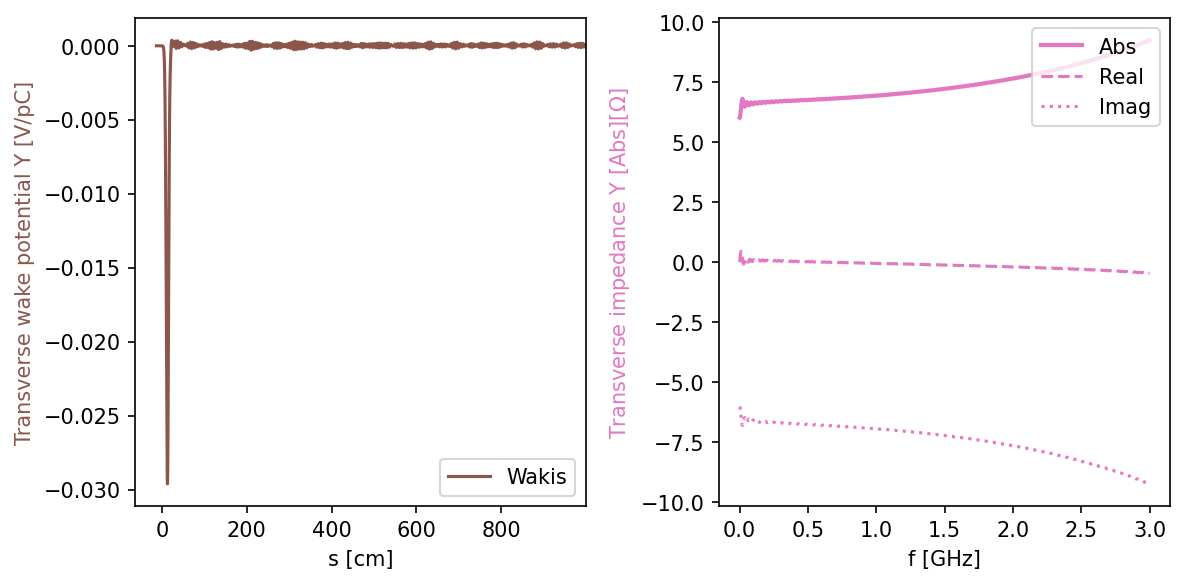

In [28]:
# Plot transverse y wake potential and impedance
fig3, ax = plt.subplots(1,2, figsize=[8,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
ax[1].legend()

fig3.tight_layout()
#fig3.savefig(results_folder+'transverse_y.png')
#plt.show()